### IMPORTS

In [221]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from nltk.stem import WordNetLemmatizer

### DATA LOAD

In [222]:
directory='datasets/train-task2-TC.labels'
props_=open(directory).read().split('\n')[:-1]
sentences, labels=[],[]
for prop in props_:
    prop_=prop.split('\t')
    x,y=int(prop_[2]),int(prop_[3])
    sentences.append(open('datasets/train-articles/article{}.txt'.format(prop_[0])).read()[x:y])
    labels.append(prop_[1])
    ids=int(prop_[0])

# General 
df=pd.DataFrame({'Sentence':sentences, 'Label':labels}).drop_duplicates()
df['Words']=df['Sentence'].str.count(' ')+1

### Text PreProcessing

In [223]:
def clean(text):
    text=text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text=re.sub('[“"”]',' " ',text)
    retain='[^abcdefghijklmnopqrstuvwxyz!#?" ]'
    text=re.sub('[()–-]',' ',text)
    text=re.sub(retain,'',text)
    text=text.replace('?',' ? ')
    text=text.replace('#',' # ')
    text=text.replace('!',' ! ')
    return ' '.join(text.split())

df['Sentence']=df['Sentence'].apply(lambda x : clean(x))
props=dict()
for i in set(df['Label']):
    props[i]=df[df['Label']==i]
le = LabelEncoder()
le.fit(df['Label'])
df['Target']=le.transform(df['Label'])

### Train-Valid Split

### Confusion-MATRIX

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm
np.set_printoptions(precision=2)

### TFILF

### TOPIC MODELLING

In [5]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [197]:
def compute_feature(sentence):
    feat=[]
    for prop in Propagandas:
        val=0
        for tok in sentence.split():
            if tok in tfilf[prop]:
                val=val+tfilf[prop][tok]
        feat.append(val)     
    return feat

[0.0, 0.001610305958132045, 0.00322061191626409, 1.0]

In [6]:
Propagandas=set(df['Label'])
Topic_freq=dict()
for prop in Propagandas:
    wl=(' '.join(df[df['Label']==prop]['Sentence'].tolist())).split(' ')
    Topic_freq[prop]=wordListToFreqDict(wl)

In [7]:
wl=(' '.join(df['Sentence'].tolist())).split(' ')
freq=wordListToFreqDict(wl)

In [85]:
tfilf=dict()
L=len(df)
for prop in Topic_freq:
    tfilf[prop]=dict()
    l=len(df[df['Label']==prop])
    for word in Topic_freq[prop]:
        if freq[word]>85:
            num=Topic_freq[prop][word]/l
            den=(freq[word]-Topic_freq[prop][word])/(L-l)
            if num/den > 1 :
                tfilf[prop][word]=num/den

In [198]:
Data=pd.DataFrame([compute_feature(sentence) for sentence in df['Sentence'].tolist()])
Data=Data.join(df).drop(['Sentence','Label'],axis=1)

In [207]:
Data.dropna(inplace=True)
Data.drop([0,3,6],axis=1,inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(Data.drop(['Target',],axis=1), Data['Target'], test_size=500, stratify=Data['Target'])
sm = SMOTE(random_state = 22)
X_train_res, y_train_res = sm.fit_sample(X_train, Y_train.ravel())

In [209]:
Data.sum()

1         55992.547290
2         37462.003107
4          8565.444417
5          4570.686360
7         42307.101114
8         54465.713766
9         30519.048622
10        36961.364085
11         8264.559414
12        47189.121278
13        58676.392427
Words     44053.000000
Target    37617.000000
dtype: float64

In [213]:
model=MultinomialNB()
model.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
Normalized confusion matrix
22.4
9.909738663951785


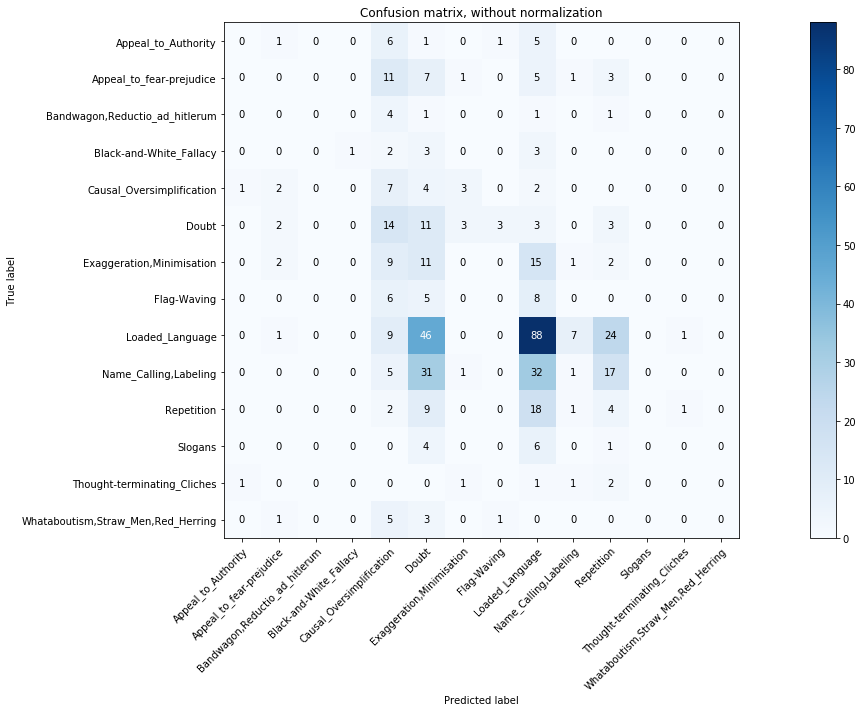

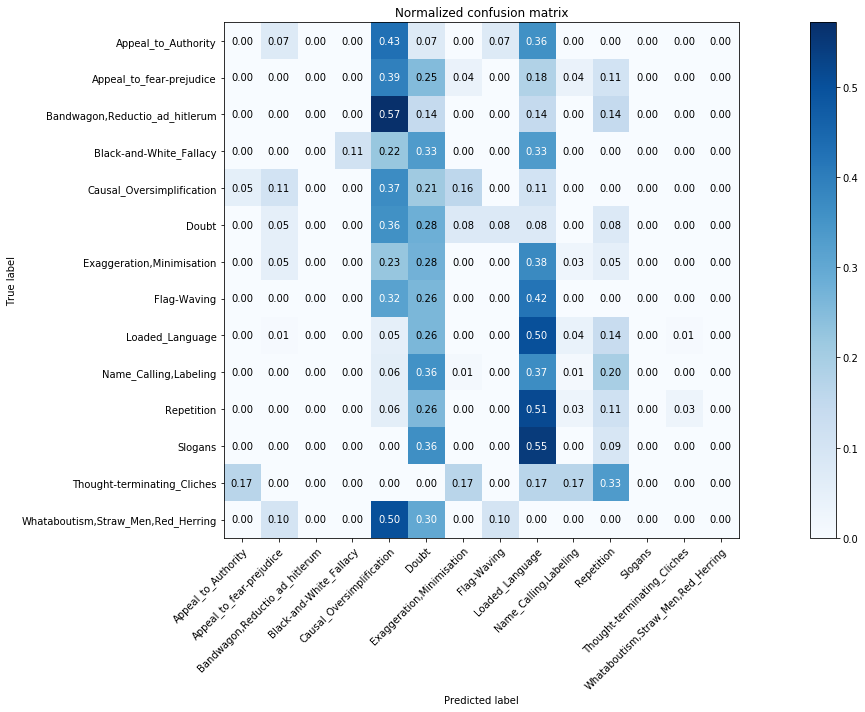

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        14
          Appeal_to_fear-prejudice       0.00      0.00      0.00        28
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         7
           Black-and-White_Fallacy       1.00      0.11      0.20         9
         Causal_Oversimplification       0.09      0.37      0.14        19
                             Doubt       0.08      0.28      0.13        39
         Exaggeration,Minimisation       0.00      0.00      0.00        40
                       Flag-Waving       0.00      0.00      0.00        19
                   Loaded_Language       0.47      0.50      0.48       176
             Name_Calling,Labeling       0.08      0.01      0.02        87
                        Repetition       0.07      0.11      0.09        35
                           Slogans       0.00      0.00      0.00        11
       Thou

/home/somesh/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [214]:
y_pred, test_class = model.predict(X_test), Y_test
classes=le.inverse_transform([i for i in range(14)])

# Plot non-normalized confusion matrix
CM=plot_confusion_matrix(test_class, y_pred, classes=classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
CM_N=plot_confusion_matrix(test_class, y_pred, classes=classes, normalize=True, title='Normalized confusion matrix')
print(CM.trace()/5)
print(CM_N.trace()*(100/14))
plt.show()
print(classification_report(test_class, y_pred, target_names=classes))

## XGB GRID

In [42]:
### A parameter grid for XGBoost
params = {
        'min_child_weight': [2, 3],
        'gamma': [1.5],
        'subsample': [0.95, 1.0],
        'colsample_bytree': [0.95, 1.0],
        'max_depth': [11, 12,13],
        'num_classes' : [14]
        }
xgb = XGBClassifier(learning_rate=0.01, n_estimators=1024, objective='multi:softmax',
                    silent=True, nthread=1)

In [43]:
%%time
folds = 3
param_comb = 4
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train, Y_train), verbose=0, random_state=1001 )
random_search.fit(X_train, Y_train)

CPU times: user 1min 56s, sys: 296 ms, total: 1min 57s
Wall time: 7min 38s


In [44]:
print('\n Best estimator:')
print(random_search.best_estimator_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=1.5, learning_rate=0.01,
       max_delta_step=0, max_depth=13, min_child_weight=3, missing=None,
       n_estimators=1024, n_jobs=1, nthread=1, num_classes=14,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)


In [57]:
MODEL='MNB'
if MODEL=='XGB' :
    model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=1.5, learning_rate=0.01,
       max_delta_step=0, max_depth=13, min_child_weight=3, missing=None,
       n_estimators=1024, n_jobs=1, nthread=1, num_classes=14,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)
    model.fit(X_train, Y_train, eval_metric='merror')
else :
    model=MultinomialNB()
    model.fit(X_train, Y_train)

Confusion matrix, without normalization
Normalized confusion matrix


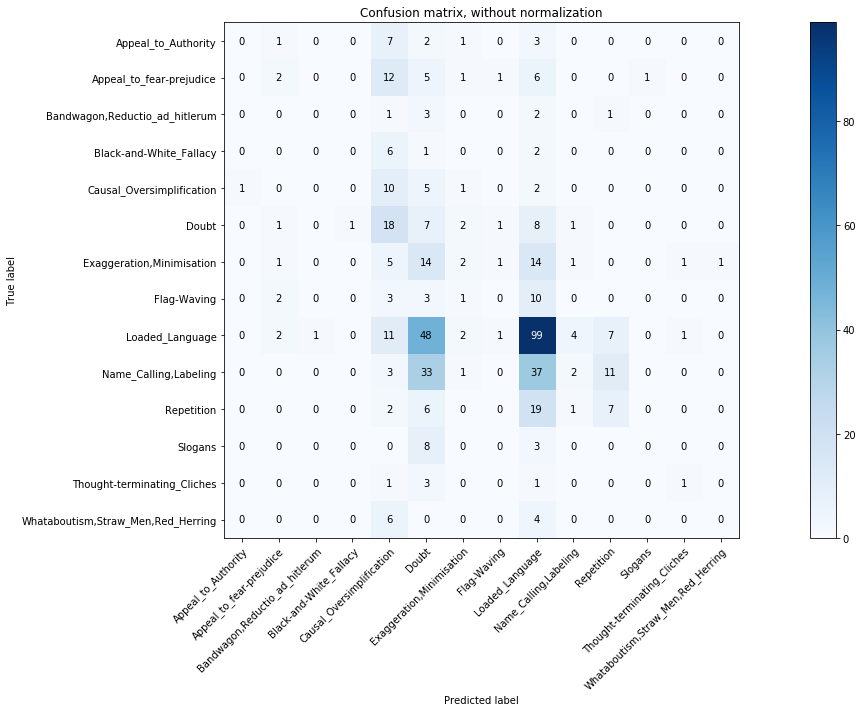

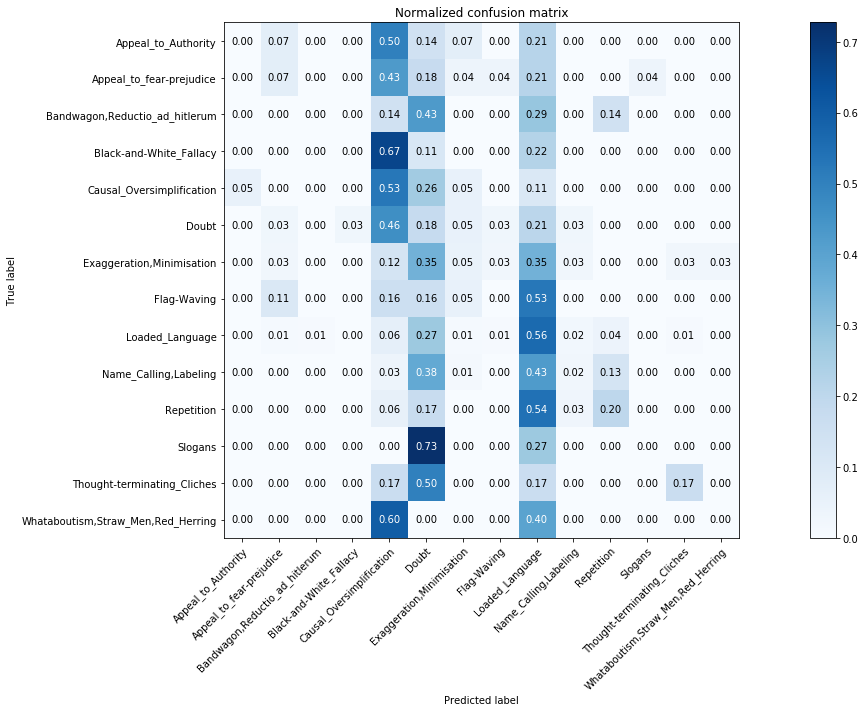

26.0
12.709905091451631
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        14
          Appeal_to_fear-prejudice       0.22      0.07      0.11        28
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         7
           Black-and-White_Fallacy       0.00      0.00      0.00         9
         Causal_Oversimplification       0.12      0.53      0.19        19
                             Doubt       0.05      0.18      0.08        39
         Exaggeration,Minimisation       0.18      0.05      0.08        40
                       Flag-Waving       0.00      0.00      0.00        19
                   Loaded_Language       0.47      0.56      0.51       176
             Name_Calling,Labeling       0.22      0.02      0.04        87
                        Repetition       0.27      0.20      0.23        35
                           Slogans       0.00      0.00      0.

In [58]:
y_pred, test_class = model.predict(X_test), Y_test
classes=le.inverse_transform([i for i in range(14)])

# Plot non-normalized confusion matrix
CM=plot_confusion_matrix(test_class, y_pred, classes=classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
CM_N=plot_confusion_matrix(test_class, y_pred, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()
print(CM.trace()/5)
print(CM_N.trace()*(100/14))
print(classification_report(test_class, y_pred, target_names=classes))

In [224]:
df['Sentence']

0       the next transmission could be more pronounced...
1       when the plague comes again it starts from mor...
2                                                appeared
3                                   a very very different
4       he also pointed to the presence of the pneumon...
5                 but warned that the danger was not over
6       the magnitude in the next transmission could b...
7       it could even spill over into neighbouring cou...
8                            stop islamization of america
9       we condemn all those whose behaviours and view...
10                                         defeat jihad "
11      the nation that gave the world the magna carta...
12      the uk should never become a stage for inflamm...
13                                         hate preachers
14                          delighted " with the decision
15                        a striking blow against freedom
16      so called land of democracy and freedom of speech
17            